In [165]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

from math import pi, sqrt, acos
from fractions import Fraction

import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
IBMQ.load_accounts()

In [4]:
def execute_circ(circ, shots):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend=backend, shots=shots)
    result = job.result()
    answer = result.get_counts()
    
    return answer

In [5]:
def evaluate_prob(answer,shots,haveAnc=False):
    
    answer_prob = [[0,0], [0,0]]
    
    if not haveAnc:
        for state, freq in answer.items():
            system = int(state[-1])
            pointer= int(state[-2])
            answer_prob[system][pointer] += freq/shots
    
    else:
        for state, freq in answer.items():
            system = int(state[-1])
            pointer= int(state[-2])
            if (int(state[0]) == 0) and (int(state[1]) == 0):
                answer_prob[system][pointer] += freq/shots
          
    return answer_prob

In [114]:
def circuit_joint_prob_ope(theta):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2,pi/2,0,qr[0])
    circ.u3(theta,0,0,qr[1])
        
    # Apply inverted CNOT gate
    circ.cx(qr[1], qr[0])
    
    # Measure pointer in M = Pauli X
    circ.h(qr[1])      
    circ.measure(qr[1],cr[1])
    circ.barrier()
    
    # Measure system in B = Pauli Z
    circ.measure(qr[0],cr[0])
    
    return circ

In [7]:
def circuit_observable(theta, observable):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2, pi/2, 0, qr[0])
    circ.u3(theta, 0, 0, qr[1])
    
    if observable == 'X':
        # Measure system in Pauli X
        circ.h(qr[0])
    if observable == 'Z':
        # Measure system in Pauli Z
        circ.iden(qr[0])
    circ.measure(qr,cr)
    
    return circ

In [43]:
def calculate_joint_prob_ope(theta):
    circ = circuit_joint_prob_ope(theta)
    
    shots = 10000
    answer = execute_circ(circ,shots)
    answer_prob = evaluate_prob(answer,shots)
    
    observable_states = {0: 1,
                         1: -1} # The same for both A=M=X and B=Z
    
    # Joint probability for 2 postselection options
    joint_prob = [0,0]
    joint_prob[0] = sum(eigenvalue**2 * answer_prob[0][state] for state,eigenvalue in observable_states.items())
    joint_prob[1] = sum(eigenvalue**2 * answer_prob[1][state] for state,eigenvalue in observable_states.items())    

    return joint_prob

In [44]:
def calculate_observable(theta, observable):
    circ = circuit_observable(theta, observable)

    shots = 10000
    answer = execute_circ(circ, shots)
    answer_prob = evaluate_prob(answer, shots)
    
    observable_states = {0: 1,
                        1: -1} # The same for both A=M=X and B=Z
    
    # Expectation value of observable
    res = sum(eigenvalue**2 * (sum(prob for prob in answer_prob[state])) for state,eigenvalue in observable_states.items())
    return res

# Evaluating error

# Create circuit for evaluating <<M^2_out>>
Following (Eq.20) and its description, I measure the pointer in the Hadamard basis as M=X. The result is divided into two parts conditional upon the presence of 2 post-selection states 

# Create circuit for evaluating <<A^2_in>>
Following (Eq.21) and its description, A=X has two eigenvalues a = +1 and -1 corresponding to eigenstates |a⟩ =  |+⟩ and |-⟩ respectively. The expectation value ⟨A⟩ = ⟨psi|a⟩ * ⟨a|psi⟩ = Probability of outcome |a⟩ when the system is initialized in |psi⟩.

For those reasons, the system qubit is rotated into Hadamard basis before measurement.

# Create circuit for evaluating − <<M_out A_in + A_in M_out>>
Following (Eq.22) and its description, I create three distinct circuits to evaluate every term, then multiply the expectation values with regarding eigenvalues m of M=X

In [33]:
def circuit_error_3state(step, theta):
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2, pi/2, 0, qr[0])
    circ.u3(theta, 0, 0, qr[1])
    
    # Three-state method applied
    if (step == 0):
        # Do nothing
        circ.iden(qr[0])
    if (step == 1):
        # A\psi = X\psi
        circ.x(qr[0])
    if (step == 2):
        circ.u2(0,0,qr[0])

        circ.x(qr[0])
        circ.cx(qr[0],qr[2])
        circ.measure(qr[2],cr[2])
        circ.barrier(qr)
        circ.x(qr[0])
        circ.cz(qr[0],qr[3])
        circ.measure(qr[3],cr[3])
        circ.barrier(qr)

        circ.u2(pi,pi,qr[0])
    

    # Apply inverted CNOT gate
    circ.cx(qr[1], qr[0])
    
    # Measure pointer in M = Pauli X
    circ.h(qr[1])
    circ.measure(qr[1],cr[1])
    circ.barrier()
    
    # Measure system in B = Pauli Z
    circ.measure(qr[0],cr[0])
    
    return circ

In [56]:
def calculate_error_3state(theta):
    shots = 10000
    
    pointer_states = {0: 1,
                      1: -1}
    
    # Errors for 2 postselection options of each step
    three_state_terms = [[0,0], [0,0], [0,0]]
    
    for step in range(3):
        circ = circuit_error_3state(step,theta)
        answer = execute_circ(circ,shots)
        if (step != 2):
            answer_prob = evaluate_prob(answer, shots)
        else:
            answer_prob = evaluate_prob(answer, shots, True)
            
        three_state_terms[step][0] = sum(eigenvalue * answer_prob[0][state] for state,eigenvalue in pointer_states.items())
        three_state_terms[step][1] = sum(eigenvalue * answer_prob[1][state] for state,eigenvalue in pointer_states.items())    
        
    three_state_error = [0,0]    
    three_state_error[0] = three_state_terms[0][0] + three_state_terms[1][0] - 4*three_state_terms[2][0]
    three_state_error[1] = three_state_terms[0][1] + three_state_terms[1][1] - 4*three_state_terms[2][1]
    
    return three_state_error

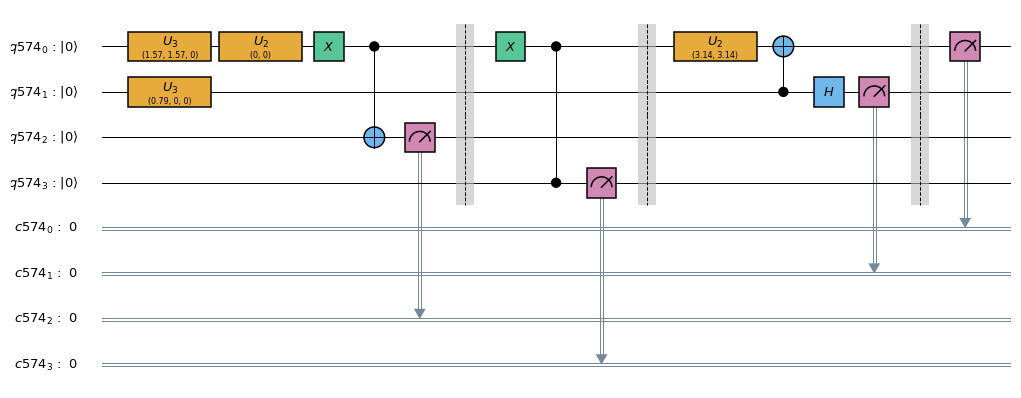

In [57]:
theta = pi/4
circ = circuit_error_3state(2,theta)
circ.draw(output='mpl')

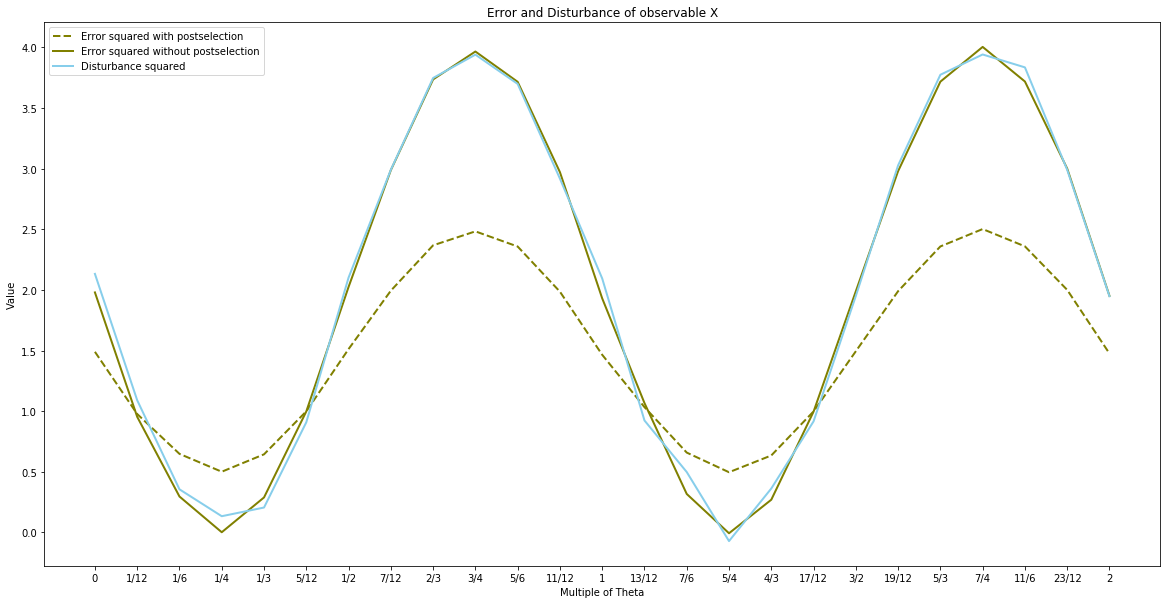

In [191]:
error_squared_with_ps = {}
error_squared_without_ps = {}
error_squared_with_ps_data = []
error_squared_without_ps_data = []
disturbance_squared_data = []
params = []

for i in range(0,49,2):
    theta = pi * i/12
    first_term = calculate_joint_prob_ope(theta)
    second_term = calculate_observable(theta,"X")
    third_term = calculate_error_3state(theta)
    
    dis_first_term = calculate_joint_prob_ope(theta)
    dis_second_term = calculate_observable(theta,"Z")
    dis_third_term = calculate_disturbance_3state(theta)
    
    # Theta in this code is twice the theta written in paper due to technical reason with U3 rotation. 
    # Theta values in the output below will be the same as in the paper.
    frac_theta = str(Fraction(i,12*2))
    
    error_squared_with_ps[frac_theta + "*pi"] = (first_term[0]+first_term[1])/2 + second_term + (third_term[0]+third_term[1])/2
    error_squared_without_ps[frac_theta + "*pi"] = (first_term[0]+first_term[1]) + second_term + (third_term[0]+third_term[1])
    disturbance_squared[frac_theta + "*pi"] = (dis_first_term[0]+dis_first_term[1]) + dis_second_term + (dis_third_term[0]+dis_third_term[1])
    
    error_squared_with_ps_data.append(error_squared_with_ps[frac_theta + "*pi"])
    error_squared_without_ps_data.append(error_squared_without_ps[frac_theta + "*pi"])
    disturbance_squared_data.append(disturbance_squared[frac_theta + "*pi"])
    params.append(frac_theta)
#print(error_squared_with_ps)
#print("\n")
#print(error_squared_without_ps)

df = pd.DataFrame({'theta': params, 'ep': error_squared_with_ps_data, 'en': error_squared_without_ps_data, 'd': disturbance_squared_data})

plt.figure(figsize=(20,10))
plt.plot( 'theta', 'ep', data=df, marker='', color='olive', linestyle='dashed', linewidth=2, label="Error squared with postselection")
plt.plot( 'theta', 'en', data=df, marker='', color='olive', linewidth=2, label='Error squared without postselection')
plt.plot( 'theta', 'd', data=df, marker='', color='skyblue', linewidth=2, label='Disturbance squared')
plt.title('Error and Disturbance of observable X')
plt.xlabel('Multiple of Theta')
plt.ylabel('Value')
plt.legend()


# Evaluating disturbance

In [189]:
def circuit_disturbance_3state(step,theta):
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    circ = QuantumCircuit(qr,cr)
    
    # Initialize system and pointer states
    circ.u3(pi/2, pi/2, 0, qr[0])
    circ.u3(theta, 0, 0, qr[1])
    
    # Three-state method applied
    if (step == 0):
        # Do nothing
        circ.iden(qr[0])
    if (step == 1):
        # B\psi = Z\psi
        circ.z(qr[0])
    if (step == 2):
        a = -sqrt(2+sqrt(2))/2
        b = - (sqrt(2)-1)*a
        #circ.u3(2*acos(a),pi,pi,qr[0])
        circ.u3(2*acos(a),pi,0,qr[0])

        circ.x(qr[0])
        temp_1 = (sqrt(2)+1)/4
        circ.cu3(2*acos(temp_1),0,pi,qr[0],qr[2])
        circ.measure(qr[2],cr[2])
        circ.barrier(qr)
        
        circ.x(qr[0])
        temp_2 = (sqrt(2)-1)/4
        circ.cu3(2*acos(temp_2),0,pi,qr[0],qr[3])
        circ.measure(qr[3],cr[3])
        circ.barrier(qr)

        #circ.u3(2*acos(a),pi,0,qr[0])
        circ.u3(2*acos(a),pi,pi,qr[0])

    # Apply inverted CNOT gate
    circ.cx(qr[1], qr[0])
    
    # Measure pointer in M = Pauli X
    circ.h(qr[1])
    circ.measure(qr[1],cr[1])
    circ.barrier()
    
    
    # Measure system in B = Pauli Z
    circ.measure(qr[0],cr[0])
    
    return circ

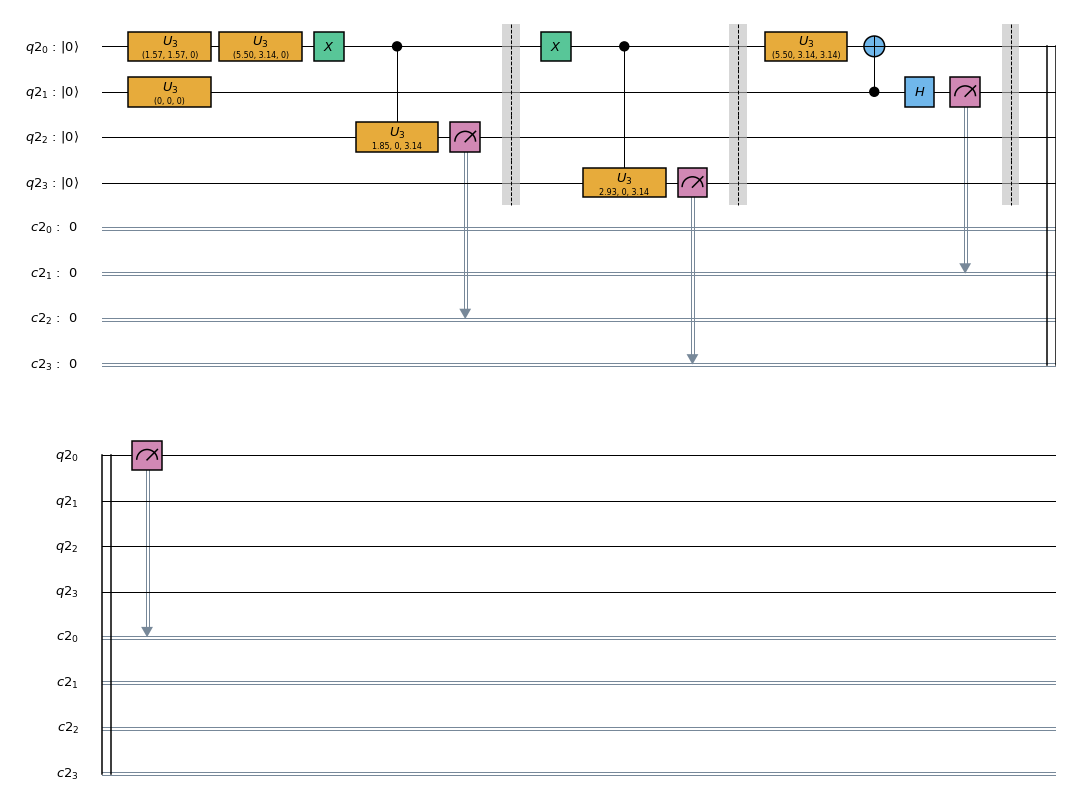

In [20]:
circ = circuit_disturbance_3state(2,0)
circ.draw(output='mpl')

In [187]:
def calculate_disturbance_3state(theta):
    shots = 10000
    
    observable_states = {0: 1,
                      1: -1}
    
    # lastpart for 2 postselection options of each term
    three_state_terms = [[0,0], [0,0], [0,0]]
    
    for step in range(3):
        circ = circuit_disturbance_3state(step,theta)
        
        answer = execute_circ(circ,shots)
        if (step != 2):
            answer_prob = evaluate_prob(answer, shots)
        else:
            answer_prob = evaluate_prob(answer, shots, True)
            
        three_state_terms[step][0] = sum(eigenvalue * answer_prob[0][state] for state,eigenvalue in observable_states.items())
        three_state_terms[step][1] = sum(eigenvalue * answer_prob[1][state] for state,eigenvalue in observable_states.items())    
        
    three_state_disturbance = [0,0]    
    three_state_disturbance[0] = three_state_terms[0][0] + three_state_terms[1][0] - 16*three_state_terms[2][0]
    three_state_disturbance[1] = three_state_terms[0][1] + three_state_terms[1][1] - 16*three_state_terms[2][1]
    
    return three_state_disturbance

In [159]:
disturbance_squared_with_ps = {}
disturbance_squared_without_ps = {}
for i in range(0,25):
    theta = pi * i/12
    first_term = calculate_joint_prob_ope(theta)
    second_term = calculate_observable(theta,"Z")
    third_term = calculate_disturbance_3state(theta)
    
    # Theta in this code is twice the theta written in paper due to technical reason with U3 rotation. 
    # Theta values in the output below will be the same as in the paper.
    frac_theta = str(Fraction(i,12*2))
    
    disturbance_squared_with_ps[frac_theta + "*pi"] = (first_term[0]+first_term[1])/2 + second_term + (third_term[0]+third_term[1])/2
    disturbance_squared_without_ps[frac_theta + "*pi"] = (first_term[0]+first_term[1]) + second_term + (third_term[0]+third_term[1])
    
print(disturbance_squared_with_ps)
print("\n")
print(disturbance_squared_without_ps)

{'0*pi': 1.5126, '1/24*pi': 1.2584, '1/12*pi': 1.0187, '1/8*pi': 0.7411, '1/6*pi': 0.6536000000000001, '5/24*pi': 0.5132000000000001, '1/4*pi': 0.4861, '7/24*pi': 0.5751999999999999, '1/3*pi': 0.5983, '3/8*pi': 0.7398000000000001, '5/12*pi': 0.9583, '11/24*pi': 1.2154000000000003, '1/2*pi': 1.4672, '13/24*pi': 1.7649, '7/12*pi': 1.9887, '5/8*pi': 2.2087, '2/3*pi': 2.3628, '17/24*pi': 2.4297, '3/4*pi': 2.4745, '19/24*pi': 2.3992999999999998, '5/6*pi': 2.3373, '7/8*pi': 2.206, '11/12*pi': 1.9943, '23/24*pi': 1.7434, '1*pi': 1.5079}


{'0*pi': 2.0252, '1/24*pi': 1.5168, '1/12*pi': 1.0374, '1/8*pi': 0.48219999999999996, '1/6*pi': 0.30720000000000014, '5/24*pi': 0.0264000000000002, '1/4*pi': -0.027800000000000047, '7/24*pi': 0.15039999999999987, '1/3*pi': 0.1966000000000001, '3/8*pi': 0.47960000000000025, '5/12*pi': 0.9166000000000001, '11/24*pi': 1.4308000000000003, '1/2*pi': 1.9344, '13/24*pi': 2.5298, '7/12*pi': 2.9774, '5/8*pi': 3.4173999999999998, '2/3*pi': 3.7256, '17/24*pi': 3.8594, 